# Data analysis of sentiments and opinion trends in the 2024 Mexican presidential debates

This study examines the **sentiment** and **opinion trends** of the **top three most-watched 2024 Mexican presidential debates on YouTube**, employing **natural language processing**, **sentiment analysis**, and **statistical methods**. Python, SQL, and Power BI are utilized to collect, process, and visualize the data.

## 1. Install tools

Installation of the main tools for the development of this project, in which SpaCy and NLTK stand out for the application of natural language processing (NLP).

In [1]:
!pip install transformers torch
!pip install spacy
!python -m spacy download es_core_news_sm
!pip install pysentimiento
!pip install nltk

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 64.7 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 586.9/586.9 kB 32.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 782.2 kB/s eta 0:00:00


## 2. Import tools

Importation of the necessary Python packages for data collection, preprocessing, storage, and analysis. Importation of tools for NLP, SQLite database, and visualization generation.

In [2]:
from matplotlib.colors import LinearSegmentedColormap
from googleapiclient.discovery import build
from pysentimiento import create_analyzer
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
from PIL import Image
import pandas as pd
import numpy as np
import sqlite3
import spacy
import nltk
import uuid
import sys
import os
import re

# download stopwords from nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

## 3. Data collection

Data was collected in two phases. First, we accessed YouTube directly and used a search filter to identify the most-watched video for each of the three presidential debates. Videos exceeding expected durations were excluded. The video links were then collected. In the second phase, we extracted information using the YouTube V3 API in a Python environment. This API is freely provided by Google Cloud Products.

- First debate: https://www.youtube.com/watch?v=kZaucITWv00&t=1051s

- Second debate: https://www.youtube.com/watch?v=0osEeTQLk3Q

- Third debate: https://www.youtube.com/watch?v=DEbALmrsZs8


### Functions

In [3]:
# Function to retrieve metadata of an specific youtube video
def get_video_data(video_id, youtube):
    """
    Retrieves metadata for a specific YouTube video.

    Args:
        video_id: The ID of the YouTube video.
        youtube: An instance of the YouTube API client.

    Returns:
        A pandas DataFrame containing the video metadata
        (title, channel title, publish date, view count, like count),
        or None if no video is found.
    """
    request = youtube.videos().list(
        part='snippet,statistics,contentDetails',
        id=video_id
    )
    response = request.execute()
    # video data response
    video_data = response['items'][0]
    # Extract relevant data
    video_info = {
        'video_id': video_data['id'],
        'title': video_data['snippet']['title'],
        'channel_title': video_data['snippet']['channelTitle'],
        'published_at': video_data['snippet']['publishedAt'],
        'view_count': int(video_data['statistics']['viewCount']),
        'like_count': int(video_data['statistics']['likeCount']),
    }
    return video_info


# Function to retrieve comments of a youtube video
def get_comments_data(video_id, youtube):
    """
    Retrieves comments for a specific YouTube video, handling pagination.

    Args:
        video_id: The ID of the YouTube video.
        youtube: An instance of the YouTube API client.

    Returns:
        A pandas DataFrame containing the comments data
        (user name, comment text, number of likes, last update timestamp).
    """

    comments = []
    next_page_token = None

    while True:
        request = youtube.commentThreads().list(
            part='snippet',
            videoId=video_id,
            maxResults=100,
            pageToken=next_page_token
  # use next_page_token for pagination
        )
        response = request.execute()
        for item in response['items']:
            comment = item['snippet']['topLevelComment']['snippet']
            comments.append({
                'video_id': response['items'][0]['snippet']['videoId'],
                'user_name': comment['authorDisplayName'],
                'comment': comment['textDisplay'],
                'n_likes': comment['likeCount'],
                'updated_at': comment['updatedAt']
            })

        next_page_token = response.get('nextPageToken')
        if not next_page_token:
            break
    return comments


# Function to scrape youtube videos data and comments data using YouTube Data 3.0 API
def collect_youtube_video_data(videos_ids, youtube):
    # arrays to save data
    videos_data = []
    comments_data = []
    # collect video data
    for id in videos_ids:
        # retrive data
        video_data = get_video_data(video_id=id, youtube=youtube)
        comments = get_comments_data(video_id=id, youtube=youtube)
        # save data
        videos_data.append(video_data)
        comments_data.extend(comments)
    # save data in dataframes
    videos_data = pd.DataFrame(videos_data)
    comments_data = pd.DataFrame(comments_data)
    return videos_data, comments_data


# Function to save data into a sqlite db
def save_to_db(dataframe, db_dir, db_name, table_name):
    # create path where db will be save
    db_path = os.path.join(db_dir, db_name)
    # connect to db
    conn = sqlite3.connect(db_path)
    # save dataframe in a table into the db
    dataframe.to_sql(table_name, conn, if_exists='replace', index=False)
    # close connection
    conn.close()


# Function to make sql query in a db en retrive result in a dataframe
def make_sql_query(db_dir, db_name, query):
    # create path where db will be save
    db_path = os.path.join(db_dir, db_name)
    # connect to db
    conn = sqlite3.connect(db_path)
    # save query result in a df
    dataframe = pd.read_sql(query, conn)
    # close connection
    conn.close()
    return dataframe

### Download data

In [4]:
# Define a YT API Key
youtube_api_key = ""

# Build the YouTube API client
youtube = build("youtube", "v3", developerKey=youtube_api_key)

# Youtube videos IDs (pre-selected)
videos_ids = ["kZaucITWv00", "0osEeTQLk3Q", "DEbALmrsZs8"]

# Collect data
videos_data, comments_data = collect_youtube_video_data(videos_ids=videos_ids, youtube=youtube)

# Show data
comments_data.head(3)

,video_id,user_name,comment,n_likes,updated_at
0,kZaucITWv00,@AvelinaBautistadeJesús,Q bueno q quitaron la Esc. de tiempo completo ...,1,2024-10-08T02:21:17Z
1,kZaucITWv00,@MrJaguzman01,Para la botarga Galvez los precios no son etic...,1,2024-09-22T11:09:54Z
2,kZaucITWv00,@HnoDanielelamigodelosbom-px5is,Mentiras del debate,1,2024-09-03T05:32:21Z


### Create database

To store and efficiently access both raw and processed data, a relational database was created using SQLite. Given its simplicity and suitability for smaller datasets, SQLite was chosen. The database was saved as a .db file.

In [5]:
# Create a new column with 4 digits-unique IDs for comments
comments_data['comment_id'] = [str(uuid.uuid1()) for _ in range(comments_data.shape[0])]

# Get project directory
project_dir = os.getcwd()

# Get/Create a data directory (all data will be saved here)
data_dir = os.path.join(project_dir, "data")
os.makedirs(data_dir, exist_ok=True) # check if directory exists, if not, create it

# Load data into a DataBase
save_to_db(dataframe=videos_data, db_dir=data_dir, db_name="youtube_data_analysis.db", table_name="videos")
save_to_db(dataframe=comments_data, db_dir=data_dir, db_name="youtube_data_analysis.db", table_name="comments")

comments_data.head(3)

,video_id,user_name,comment,n_likes,updated_at,comment_id
0,kZaucITWv00,@AvelinaBautistadeJesús,Q bueno q quitaron la Esc. de tiempo completo ...,1,2024-10-08T02:21:17Z,40960cce-902c-11ef-bfa3-0242ac1c000c
1,kZaucITWv00,@MrJaguzman01,Para la botarga Galvez los precios no son etic...,1,2024-09-22T11:09:54Z,40960e68-902c-11ef-bfa3-0242ac1c000c
2,kZaucITWv00,@HnoDanielelamigodelosbom-px5is,Mentiras del debate,1,2024-09-03T05:32:21Z,40960ef4-902c-11ef-bfa3-0242ac1c000c


### Results

In [6]:
# Define db directory, where db is stored
db_dir = os.path.join(os.path.dirname(os.getcwd()), "data")

# Define a sql query
query = """
        SELECT comment_id, comment
        FROM comments
        LIMIT 3
        """

# Retrieve raw data from db
make_sql_query(db_dir=data_dir, db_name="youtube_data_analysis.db", query=query)

,comment_id,comment
0,40960cce-902c-11ef-bfa3-0242ac1c000c,Q bueno q quitaron la Esc. de tiempo completo ...
1,40960e68-902c-11ef-bfa3-0242ac1c000c,Para la botarga Galvez los precios no son etic...
2,40960ef4-902c-11ef-bfa3-0242ac1c000c,Mentiras del debate


In [7]:
# Define a sql query
query = """
        SELECT COUNT(comment) AS Number_of_comments
        FROM comments
        WHERE video_id = "kZaucITWv00"
        """

# Retrieve raw data from db
make_sql_query(db_dir=data_dir, db_name="youtube_data_analysis.db", query=query)

,Number_of_comments
0,2978


## 4. Data preprocessing

For data processing, Python was used to handle date formats and text in the comments. In the case of dates, a correction was applied to standardize them to a more suitable datetime format. On the other hand, for text, various natural language processing (NLP) techniques were employed, such as:

- converting all text to lowercase,

- removing special characters like hashtags (#), mentions (@), numbers, and other symbols ($!) and URLs

- spell checking using a dictionary with typical Mexican Spanish orthographic corrections to restore the original form of words,

- lemmatization to reduce noise in the text by normalizing word variations such as verb conjugations, and

- removing stop words using a Spanish dictionary of words that serve primarily as connectors and add noise to phrases, which could affect performance in subsequent analysis.

### Functions

In [8]:
# Dictionary of common intentional orthography mexican errors
orthography_corrections = {
    # common abbreviations
    "esc": "escuela",
    "q": "que",
    "xq": "porque",
    "xk": "porque",
    "tmb": "también",
    "pa": "para",
    "k": "que",
    "ke": "que",
    "x": "por",
    "xfa": "por favor",
    "pq": "porque",
    "tqm": "te quiero mucho",
    "bno": "bueno",
    "dnd": "dónde",
    "cmo": "cómo",
    "cm": "cómo",
    "xfin": "por fin",
    "ntp": "no te preocupes",
    "vrdd": "verdad",
    "vdd": "verdad",
    "grx": "gracias",
    "grcs": "gracias",
    "kmo": "como",
    "msj": "mensaje",
    "x eso": "por eso",
    "bss": "besos",
    "bye": "adiós",
    # phonetic errors or colloquial adaptations
    "ta": "está",
    "toy": "estoy",
    "pa'": "para",
    "asi": "así",
    "io": "yo",
    "d": "de",
    "i": "y",
    "pos": "pues",
    "oie": "oye",
    "creo k": "creo que",
    "aki": "aquí",
    "alli": "allí",
    "deveras": "de veras",
    "ke onda": "qué onda",
}

# Function to correct datetime format
def correct_datetime(datetime):
    # correct datetime to a more suitable format
    datetime = pd.to_datetime(datetime)
    return datetime


# Function to remove special characters in text
def remove_special_characters(text):
    # convert all characters to lowercase
    text = text.lower()
    # remove HTML tags and attributes
    text = re.sub(r'<[^>]+>', '', text)
    # remove URLs (both http and https)
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    # remove mentions (@username)
    text = re.sub(r'@\w+', '', text)
    # remove hashtags but keep the word
    text = re.sub(r'(?<=#)\w+', '', text)
    # remove punctuation at the end of words (except for ? and !)
    text = re.sub(r'(\b\w+)[.,;:]+', r'\1', text)
    # keep only letters, spaces, and specific punctuation marks
    text = re.sub(r'[^a-zA-Z\s¡!¿?]', '', text)
    # normalize whitespace and trim
    text = re.sub(r'\s+', ' ', text).strip()
    # return the cleaned text
    return text


# Function to correct mexican-spanish orthography
def correct_ortography(text):
    # split the text into individual words
    words = text.split()
    # correct each word if it's in the corrections dictionary, otherwise keep it as is
    return ' '.join(orthography_corrections.get(word, word) for word in words)


# Function to lemmatize text
def lemmatize(text, nlp):
    # process the text with the spaCy model
    doc = nlp(text)
    # extract the lemma for each token and join them back into a string
    return ' '.join([token.lemma_ for token in doc])


# Function to preprocess text
def preprocess_text(text, nlp):
    # remove special characters from the text
    text = remove_special_characters(text=text)
    # correct common orthographic mistakes
    text = correct_ortography(text=text)
    # lemmatize the remaining words
    text = lemmatize(text=text, nlp=nlp)
    # return the fully preprocessed text
    return text

### Import data

In [9]:
# Query
query = """
        SELECT *
        FROM comments
        """

# Comments data
comments = make_sql_query(db_dir=data_dir, db_name="youtube_data_analysis.db", query=query)

### Preprocess data

In [10]:
# Load spaCy model
nlp = spacy.load("es_core_news_sm")

# Preprocess data
comments_preprocessed = comments.copy()[['comment_id']]
comments_preprocessed['comment_preprocessed'] = comments['comment'].apply(lambda x: preprocess_text(x, nlp))

# Correct datetime data
comments_preprocessed['updated_at_corrected'] = comments['updated_at'].apply(correct_datetime)

# Load preprocessed data into a db
save_to_db(dataframe=comments_preprocessed, db_dir=data_dir, db_name="youtube_data_analysis.db", table_name="comments_preprocessed")

### Results

In [11]:
# Query
query = """
        SELECT *
        FROM comments_preprocessed
        LIMIT 3
        """

# Show comments data
make_sql_query(db_dir=data_dir, db_name="youtube_data_analysis.db", query=query)

,comment_id,comment_preprocessed,updated_at_corrected
0,40960cce-902c-11ef-bfa3-0242ac1c000c,que bueno que quitar el escuela de tiempo comp...,2024-10-08 02:21:17+00:00
1,40960e68-902c-11ef-bfa3-0242ac1c000c,para el botargo galvez el precio no ser etico ...,2024-09-22 11:09:54+00:00
2,40960ef4-902c-11ef-bfa3-0242ac1c000c,mentira del debate,2024-09-03 05:32:21+00:00


#### Example:

In [12]:
# Retrieve data
query = """
        SELECT *
        FROM comments
        LIMIT 3
        """

# Comments data
comments = make_sql_query(db_dir=data_dir, db_name="youtube_data_analysis.db", query=query)

# Original first comment
comments['comment'][0]

'Q bueno q quitaron la Esc. de tiempo completo 😢😊 <a href="https://www.youtube.com/watch?v=kZaucITWv00&amp;t=2203">36:43</a>'

In [13]:
# Query
query = """
        SELECT *
        FROM comments_preprocessed
        LIMIT 3
        """

# Comments data preprocessed
comments_preprocessed = make_sql_query(db_dir=data_dir, db_name="youtube_data_analysis.db", query=query)

# Preprocess first comment
comments_preprocessed['comment_preprocessed'][0]

'que bueno que quitar el escuela de tiempo completo'

## 5. Sentiment Analysis

Additionally, a sentiment analysis was carried out in order to classify the perception in the comments as negative, positive, or neutral. For this, a sentiment analysis model freely available on the Hugging Face platform called "robertuito" was used, which was trained with around 5,000 Spanish tweets.

### Functions

In [14]:
# Function to analyze sentiment in text
def analyze_sentiment(text, analyzer):
  # get analysis results
  res = analyzer.predict(text)
  return res

### Import data

In [15]:
# Query
query = """
        SELECT comment_id, comment_preprocessed
        FROM comments_preprocessed
        """

# Comments preprocessed data
comments_preprocessed = make_sql_query(db_dir=data_dir, db_name="youtube_data_analysis.db", query=query)

### Analysis

In [16]:
# Create sentiment analyzer
analyzer = create_analyzer(task="sentiment", lang="es")

# Sentiment analysis results
sentiment_analysis = comments_preprocessed.copy()[['comment_id']]

# Apply sentiment analysis to comments
sentiment_analysis['sentiment'] = comments_preprocessed['comment_preprocessed'].apply(lambda x: analyze_sentiment(x, analyzer).output)

# Load sentiment analysis results into a db
save_to_db(dataframe=sentiment_analysis, db_dir=data_dir, db_name="youtube_data_analysis.db", table_name="sentiment_analysis")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/925 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/435M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/384 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.31M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/167 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


### Results

In [17]:
# Query
query = """
        SELECT *
        FROM sentiment_analysis
        """

# Show sentiment analysis data
sentiment_analysis = make_sql_query(db_dir=data_dir, db_name="youtube_data_analysis.db", query=query)
sentiment_analysis.head(5)

,comment_id,sentiment
0,40960cce-902c-11ef-bfa3-0242ac1c000c,NEU
1,40960e68-902c-11ef-bfa3-0242ac1c000c,NEG
2,40960ef4-902c-11ef-bfa3-0242ac1c000c,NEU
3,40960f76-902c-11ef-bfa3-0242ac1c000c,NEG
4,40960fe4-902c-11ef-bfa3-0242ac1c000c,NEU


In [18]:
sentiment_analysis['sentiment'].value_counts()

,count
sentiment,
NEG,6325
NEU,2697
POS,868


## 6. Data analysis

Finally, to answer the research questions posed, it was decided to use Power BI software, with the aim of facilitating the generation of visualizations and creating a dashboard to summarize the analysis. In this sense, storing the information in an SQL database was very useful, as it allowed creating specific queries to extract the data and load it directly into Power BI. Below are some of the questions that could be answered and the generation of the relevant visualizations.

1. What were the most frequent words in the comments of each debate?

In [19]:
spanish_mexican_stopwords = [
    # Articles
    "el", "la", "los", "las", "un", "una", "unos", "unas", "lo",
    # Personal and possessive pronouns
    "yo", "tú", "él", "ella", "nosotros", "nosotras", "ustedes", "ellos", "ellas",
    "me", "mi", "mío", "mía", "míos", "mías",
    "te", "tu", "tuyo", "tuya", "tuyos", "tuyas",
    "su", "suyo", "suya", "suyos", "suyas",
    "nuestro", "nuestra", "nuestros", "nuestras",
    "vuestro", "vuestra", "vuestros", "vuestras",
    # Demonstrative pronouns
    "este", "esta", "estos", "estas", "esto",
    "ese", "esa", "esos", "esas", "eso",
    "aquel", "aquella", "aquellos", "aquellas", "aquello",
    # Preposiciones
    "a", "ante", "bajo", "cabe", "con", "contra", "de", "desde",
    "en", "entre", "hacia", "hasta", "para", "por", "según",
    "sin", "sobre", "tras", "durante", "mediante",
    # Conjunctions
    "y", "e", "ni", "o", "u", "pero", "sino", "porque", "pues",
    "que", "si", "mas", "aunque", "sino",
    # Common adverbs
    "no", "sí", "ya", "muy", "mucho", "muchos", "mucha", "muchas",
    "más", "menos", "poco", "pocos", "poca", "pocas",
    "bien", "mal", "así", "solo", "solamente", "ahora",
    "después", "antes", "siempre", "nunca", "jamás",
    "aquí", "allí", "ahí", "donde", "cuando", "como",
    "mientras", "además", "incluso", "también",
    # Auxiliary and common verbs (in different tenses)
    "ser", "estar", "haber", "tener",
    "soy", "eres", "es", "somos", "son",
    "estoy", "estás", "está", "estamos", "están",
    "he", "has", "ha", "hemos", "han",
    "tengo", "tienes", "tiene", "tenemos", "tienen",
    "fue", "fueron", "era", "eras", "éramos", "eran",
    "había", "habías", "habíamos", "habían",
    "sea", "seas", "seamos", "sean",
    # Common numbers
    "uno", "dos", "tres", "cuatro", "cinco",
    "primera", "primero", "segundo", "segunda", "tercero", "tercera",
    # Time expressions
    "hoy", "ayer", "mañana", "tarde", "noche",
    "semana", "mes", "año", "tiempo", "momento",
    "lunes", "martes", "miércoles", "jueves", "viernes", "sábado", "domingo",
    # Mexicanisms and common colloquialisms
    "pues", "órale", "va", "nel", "nomás", "pos", "tons",
    "ora", "chale", "simón", "nel", "namás", "nomás",
    "ándale", "sale", "va", "órale", "mero", "chance",
    # Interjections and filler words
    "ah", "eh", "oh", "ay", "uy", "mmm", "este", "estee",
    "pues", "bueno", "bien", "ajá", "ok", "okay", "vale",
    "mira", "oye", "fíjate", "verás", "sabes", "ves",
    # Polite words
    "gracias", "por favor", "perdón", "disculpe", "permiso",
    # Expressions of quantity and measure
    "algo", "alguien", "nadie", "nada", "todo", "todos", "toda", "todas",
    "cada", "cualquier", "cualquiera", "bastante", "demasiado",
    # Other functional words
    "cosa", "cosas", "modo", "manera", "forma", "vez", "veces",
    "lado", "parte", "tipo", "ejemplo", "caso", "casos",
    # Expressions of affirmation/negation/doubt
    "sí", "no", "tal vez", "quizá", "quizás", "acaso", "igual",
    # Textual connectors
    "además", "sin embargo", "no obstante", "por lo tanto",
    "es decir", "o sea", "mejor dicho", "en fin", "finalmente",
    # Common compound words
    "tal vez", "sin embargo", "por favor", "es decir",
    "más o menos", "de repente", "por supuesto",
    # Common contractions and combinations
    "del", "al", "pa", "pal", "pela"
]

In [20]:
# Query
query = """
        SELECT v.title, cp.comment_preprocessed
        FROM videos v
        JOIN comments c ON v.video_id = c.video_id
        JOIN comments_preprocessed cp ON c.comment_id = cp.comment_id
        """

# Comments preprocessed data
title_comments_preprocessed = make_sql_query(db_dir=data_dir, db_name="youtube_data_analysis.db", query=query)

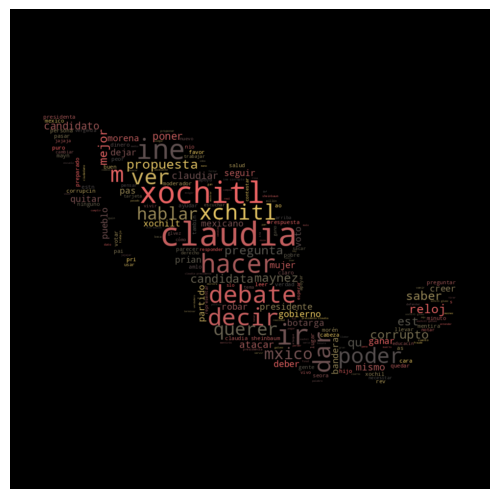

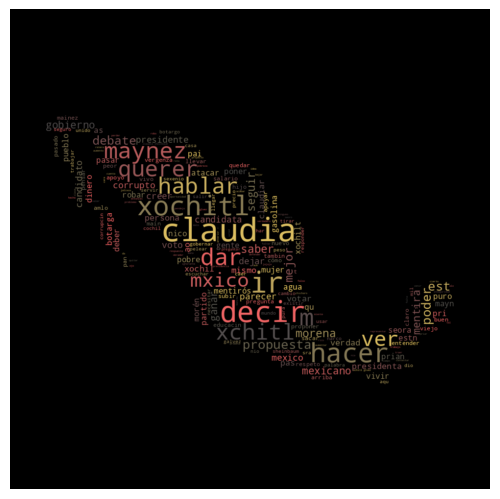

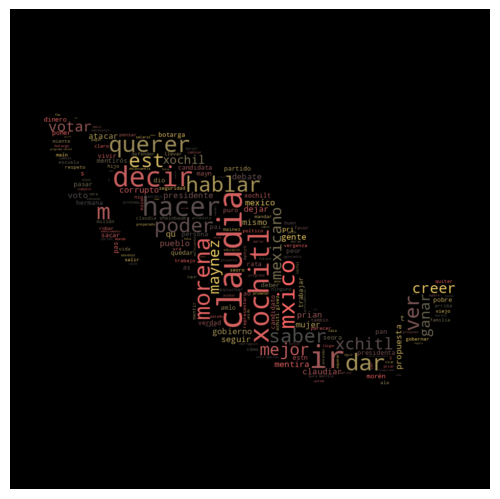

In [21]:
# Define stop words set
stopwords = set(stopwords.words('spanish'))
stopwords.update(spanish_mexican_stopwords)

# Define a custom color map based on the dashboard colors
colors = ['#ff6666', '#4d4d4d', '#ffd966']  # Rojo, negro, amarillo (colores predominantes del dashboard)
cmap = LinearSegmentedColormap.from_list("custom_cmap", colors)

# Load the mask image (the contour of Mexico)
mask_image = np.array(Image.open('mexico_map.jpg'))

# Generate a wordcloud for every video
for title in title_comments_preprocessed['title'].unique():
  # combine comments in a single text
  full_text = ' '.join(title_comments_preprocessed[title_comments_preprocessed['title'] == title]['comment_preprocessed'])
  # generate wordcloud
  wordcloud = WordCloud(width=1000, height=800, background_color='black', stopwords=stopwords, colormap=cmap, mask=mask_image).generate(full_text)
  # display the wordcloud
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis('off')
  plt.tight_layout(pad=0)
  plt.show()

2. What is the most viewed debate?

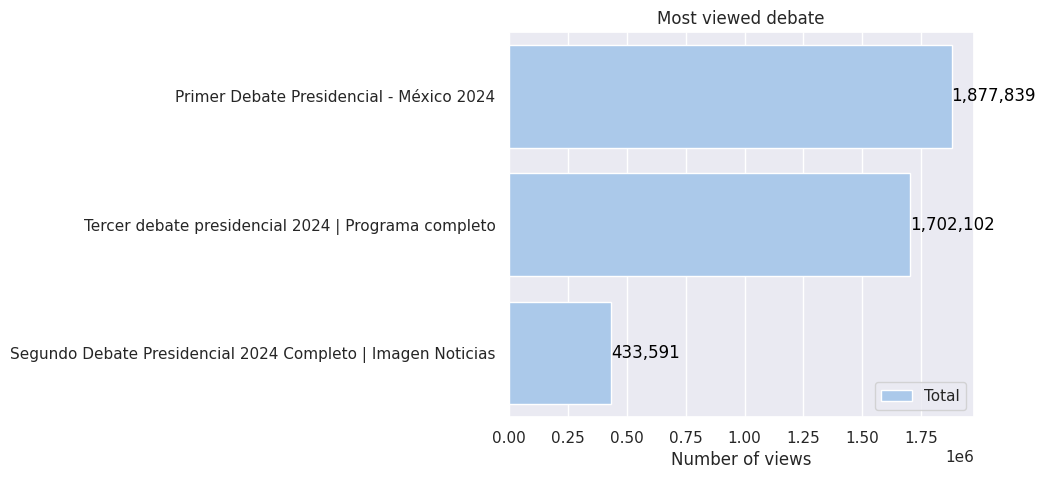

In [22]:
# Query
query = """
        SELECT title AS video_title, view_count
        FROM videos
        ORDER BY view_count DESC
        """

# Videos data
videos_views = make_sql_query(db_dir=data_dir, db_name="youtube_data_analysis.db", query=query)

# Bar plot
plt.figure(figsize=(6,5))
sns.set(style="darkgrid")
sns.set_color_codes("pastel")
sns.barplot(x="view_count", y="video_title", data=videos_views.head(10),
            label="Total", color="b")
for i, v in enumerate(videos_views['view_count']):
    plt.text(v, i, f"{v:,.0f}", color='black', va='center')
plt.xlabel("Number of views")
plt.ylabel("")
plt.title("Most viewed debate")
plt.show()

3. Which debate had the highest level of engagement (likes and comments)?

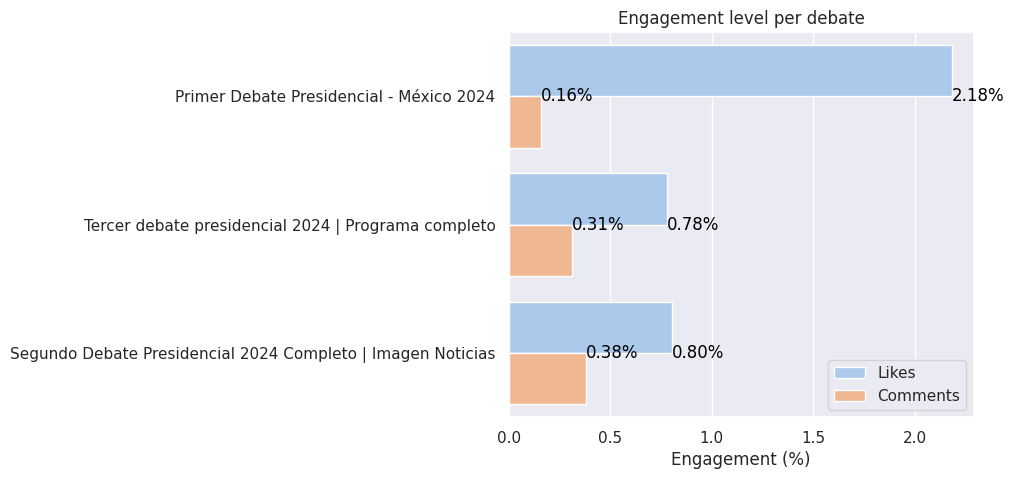

In [23]:
# Query
query = """
        SELECT v.title, v.view_count, v.like_count, COUNT(c.comment) AS comments_counts
        FROM comments c
        JOIN videos v ON c.video_id = v.video_id
        GROUP BY v.video_id
        ORDER BY v.view_count DESC
        """

# Show comments data
videos_engagement = make_sql_query(db_dir=data_dir, db_name="youtube_data_analysis.db", query=query)

# Normalize engagement values considering number of views
videos_engagement['like_perc'] = (videos_engagement['like_count'] / videos_engagement['view_count']) * 100
videos_engagement['comment_perc'] = (videos_engagement['comments_counts'] / videos_engagement['view_count']) * 100

# Transform data
engagement_melted = videos_engagement.melt(id_vars=['title'], value_vars=['like_perc', 'comment_perc'],
                                            var_name='Engagement Type', value_name='Normalized Value')

# Bar plot
plt.figure(figsize=(6,5))
sns.set(style="darkgrid")
sns.set_color_codes("pastel")
sns.barplot(x='Normalized Value', y='title', hue='Engagement Type', data=engagement_melted, palette='pastel')
titles = engagement_melted['title'].unique()
n_titles = len(titles)
for i in range(n_titles):
    like_value = engagement_melted[(engagement_melted['Engagement Type'] == "like_perc") &
                                 (engagement_melted['title'] == titles[i])]['Normalized Value'].values[0]
    plt.text(like_value, i, f"{like_value:.2f}%", color='black', va='center')
    comment_value = engagement_melted[(engagement_melted['Engagement Type'] == "comment_perc") &
                                    (engagement_melted['title'] == titles[i])]['Normalized Value'].values[0]
    plt.text(comment_value, i, f"{comment_value:.2f}%", color='black', va='center')
plt.xlabel("Engagement (%)")
plt.ylabel("")
plt.title("Engagement level per debate")
custom_labels = ['Likes', 'Comments']
handles, labels = plt.gca().get_legend_handles_labels()
for i, label in enumerate(labels):
    if label == 'like_perc':
        labels[i] = custom_labels[0]
    elif label == 'comment_perc':
        labels[i] = custom_labels[1]
plt.legend(handles, labels, title='')

plt.show()